# CS 105 Final Project
#### Jonathan Kim, Samuel Ha, Sathya Rajesh, Ian Oh
## Predict whether a taxi trip is during day or night depending on several features
New York City has a population of 8.5 million and is considered as one of the busiest cities in the United States. The public transportation system is vital for millions of Americans. The Taxi & Limousine Commission (TLC) is in charge of providing millions of taxi trips to tourists and locals every year.
### Dataset
https://www.nyc.gov/site/tlc/about/tlc-trip-record-data.page <br>
This dataset features TLC trip record data which has various data points provided regarding yellow and green taxi rides that have been recorded throughout the years. 

In this project, we will be using the dataset provided from the trips that occured in January 2018 from the yellow cabs.

### All Features included
EntryNum, VendorID, pickup and drop timedate, passenger count, trip distance, RatecodeID, store and fwd flag, pickup and drop off location ID, payment type, fare amount, extra fees, mta tax, tip amount, tolls amount, improvement surcharge, total amount, congestion surcharge, airport fee
### Project Proposal

Based on several attributes in this dataset, we are going to predict when a taxi trip occurs during day or night time. Our dataset has information that can be transformed. After adding more columns of usuable data, the main features that we will use are passenger count, trip distance, total amount, trip duration, and time of day.

Techniques used in this project:
* K-Nearest Neighbors Classification
* Decision Tree Classification


### How Dataset was chosen

We wanted to pick a year that was pre-Covid for our dataset. Covid has impacted the way people work and commute so we wanted to avoid using years starting from 2020. As a group we chose 2018. We originally wanted to use the entire year for our datasets. However, after extracting from the PARQUET file, we realized that there was too much data. In January 2018 alone, there were more than 8.6 million entries. After data cleaning, we hoped that 31 days would be enough, however, we came to the conclusion one day's worth of dataset is processible. I don't think Zubair or Elena have the 3 terabytes needed to run our KNN-classification for the entirety of January's dataset. We chose to trim our dataset from January 31st and still have 622,005 usable entries.

### Data Dictionary
Vendor ID: A code indicating the TPEP provider that provided the record (1 = Creative Mobile Technologies, LLC; 2 = VeriFone INC.) <br>
tpep_pickup_datetime: date and time when meter was engaged <br>
tpep_dropoff_datetime: date and time when meter was disengaged <br>
passenger_count: number of passengers in vehicle <br>
trip_distance: elapsed trip distance in miles <br>
PULocationID: TLC Taxi Zone in which taximeter was engaged <br>
DOLocationID: TLC Taxi Zone in which taximeter was disengaged <br>
Payment_type: A numeric code signifying how passenger paid (1 = Credit Card; 2 = Cash; 3 = No Charge; 4 = Dispute; 5 = Unknown; 6 = Voided Trip) <br>
Fare_amount: time and distance fare calculated by meter <br>
Total_amount: total amount charged to passengers <br>

In [47]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import dask.dataframe as dd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")

ddf=pd.read_csv('jan2018converted.csv/0.part')
ddf.head()

,EntryNum,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,airport_fee
0,0,1,2018-01-01 00:21:05,2018-01-01 00:24:23,1,0.5,1,N,41,24,2,4.5,0.5,0.5,0.00,0.0,0.3,5.80,NaN,NaN
1,1,1,2018-01-01 00:44:55,2018-01-01 01:03:05,1,2.7,1,N,239,140,2,14.0,0.5,0.5,0.00,0.0,0.3,15.30,NaN,NaN
2,2,1,2018-01-01 00:08:26,2018-01-01 00:14:21,2,0.8,1,N,262,141,1,6.0,0.5,0.5,1.00,0.0,0.3,8.30,NaN,NaN
3,3,1,2018-01-01 00:20:22,2018-01-01 00:52:51,1,10.2,1,N,140,257,2,33.5,0.5,0.5,0.00,0.0,0.3,34.80,NaN,NaN
4,4,1,2018-01-01 00:09:18,2018-01-01 00:27:06,2,2.5,1,N,246,239,1,12.5,0.5,0.5,2.75,0.0,0.3,16.55,NaN,NaN


## Data Clean Up
In order to use this dataset, we had to create more columns. We were able to add trip duration and time of day. Trip duration is calculated from the datetime of dropoff and pickup. We defined the hours between 6 am to 6 pm (sunrise to sunset) as daytime. The hours before and after the twelve hour period is defined as nighttime. Several features we decided to drop include VendorID, RatecodeID,store_and_fwd_flag, congestion_surcharge, airport_fee, and improvement_surcharge which were not necessary in our data collection. 

In [48]:
ddf['tpep_pickup_datetime'] = pd.to_datetime(ddf['tpep_pickup_datetime'], errors='coerce')
ddf['tpep_dropoff_datetime'] = pd.to_datetime(ddf['tpep_dropoff_datetime'], errors='coerce')

ddf['trip_duration'] = (ddf['tpep_dropoff_datetime'] - ddf['tpep_pickup_datetime']).dt.total_seconds() / 60

ddf=ddf.drop(columns=['VendorID','RatecodeID','store_and_fwd_flag', 'congestion_surcharge', 'airport_fee', 'improvement_surcharge'])

ddf['time_of_day'] = ddf['tpep_pickup_datetime'].dt.hour.between(6, 18, inclusive=True)
ddf['time_of_day'] = ddf['time_of_day'].replace({True: 'day', False: 'night'})

ddf=ddf.loc[ddf['passenger_count'] !=0]

ddf = ddf.set_index('PULocationID')

### Dataset for January 2018

In [49]:
ddf.shape

(8701418, 15)

### Dataset for January 31, 2018

In [50]:
ddf = ddf.sort_values('PULocationID',ascending=True)
ddf = ddf.loc[(ddf['tpep_pickup_datetime']) > '2018-01-30']

ddf.shape

(618034, 15)

### EDA (Exploratory Data Analysis)

In [51]:
ddf.describe()

,EntryNum,passenger_count,trip_distance,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration
count,6.180340e+05,618034.000000,618034.000000,618034.000000,618034.000000,618034.000000,618034.000000,618034.000000,618034.000000,618034.000000,618034.000000,618034.000000
mean,8.449636e+06,1.574965,2.911166,164.968414,1.274931,11.826449,0.390798,0.497785,1.871172,0.283466,15.172573,15.019696
std,1.810022e+05,1.238236,241.046712,68.963158,0.463147,12.362564,0.482322,0.036547,2.405729,1.441591,14.538123,54.677382
min,1.166000e+06,1.000000,0.000000,1.000000,1.000000,-80.000000,-4.500000,-0.500000,-0.950000,-11.520000,-80.800000,0.000000
25%,8.294241e+06,1.000000,0.900000,114.000000,1.000000,6.000000,0.000000,0.500000,0.000000,0.000000,8.300000,6.350000
50%,8.449652e+06,1.000000,1.500000,162.000000,1.000000,9.000000,0.500000,0.500000,1.500000,0.000000,11.300000,10.433333
75%,8.605196e+06,2.000000,2.700000,234.000000,2.000000,13.000000,0.500000,0.500000,2.450000,0.000000,16.560000,16.733333
max,8.760686e+06,9.000000,189483.840000,265.000000,4.000000,5724.500000,4.800000,3.000000,330.000000,212.040000,5726.300000,1439.916667


This set of data gives us many of our standard statistical attributes that pertain to our dataset. Each of our various features have these calculations to get a better grasp of the information we are given

In [52]:
passenger_count = ddf['passenger_count'].value_counts()
passenger_count

1    459868
2     80615
5     28771
3     21805
6     17546
4      9423
7         3
8         2
9         1
Name: passenger_count, dtype: int64

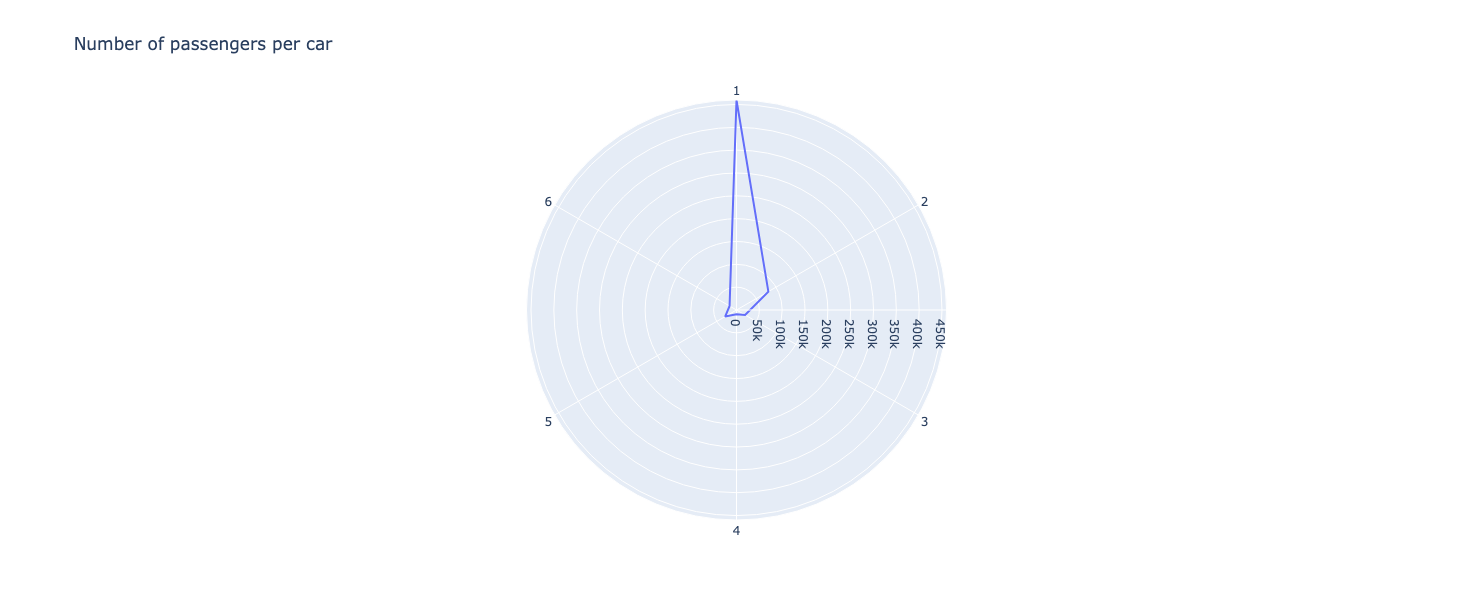

In [ ]:
import plotly.express as px
df = pd.DataFrame(dict(
    r=[459868,80567, 21795, 9412, 28743, 17531],
    theta=['1','2','3','4',
           '5', '6']))
fig = px.line_polar(df, 
                    r='r', 
                    theta='theta', 
                    line_close=True, 
                    title = "Number of passengers per car",
                    width=800, height=600
                   )
fig.show()

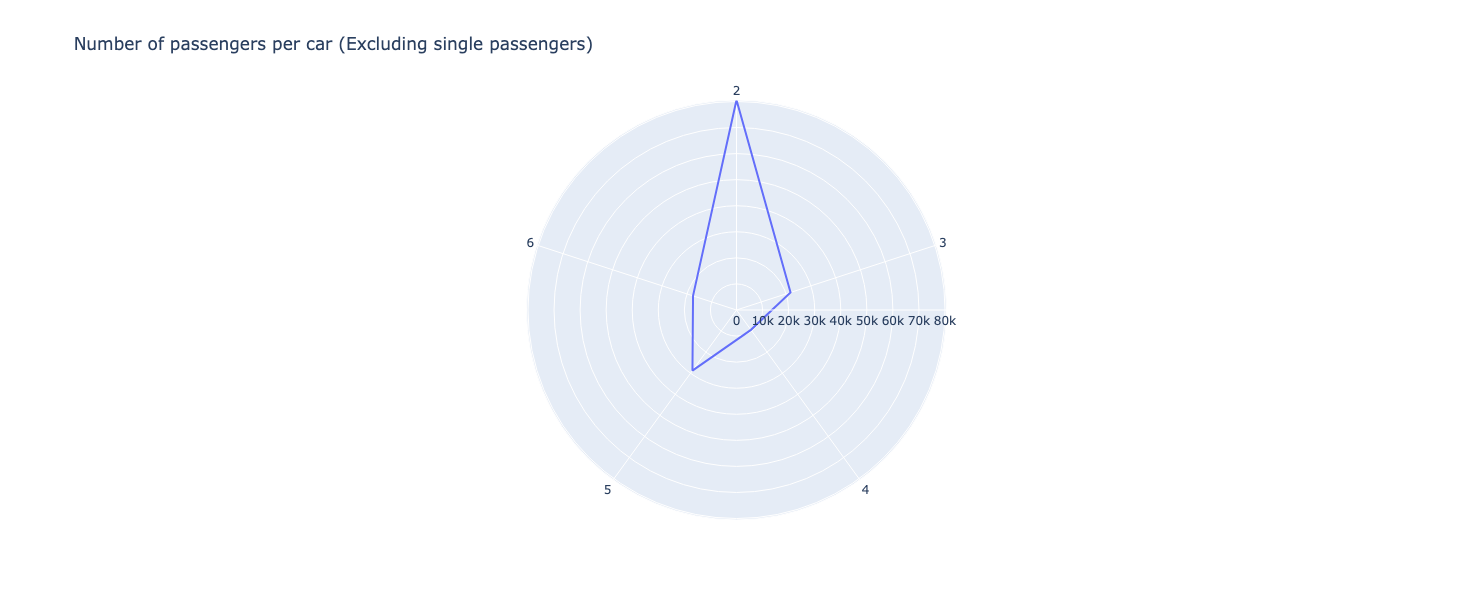

In [58]:
df2 = pd.DataFrame(dict(
    r=[80567, 21795, 9412, 28743, 17531],
    theta=['2','3','4',
           '5', '6']))
fig2 = px.line_polar(df2, 
                    r='r', 
                    theta='theta', 
                    line_close=True, 
                    title = "Number of passengers per car (Excluding single passengers)",
                    width=800, height=600
                   )
fig2.show()

In [54]:
ddf2 = ddf=ddf.loc[ddf['passenger_count'] !=1]

hmap = (
    ddf
    .groupby('time_of_day')
    .passenger_count
    .value_counts()
    .unstack()
)

<AxesSubplot:xlabel='passenger_count', ylabel='time_of_day'>

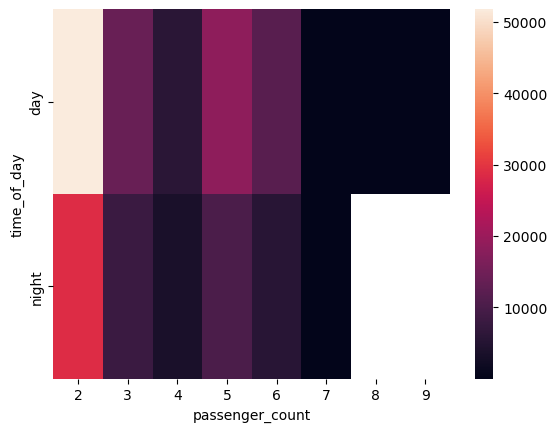

In [55]:
sns.heatmap(hmap)

This heatmap shows us the comparison between how many cars filled with a certain amount of passengers took a taxi during the day and night. The lighter shades indicate a higher frequency, and it is evident here that 2-passenger taxis were of greatest amount compared to the others. Particularly during the day we see that it had the most of that specific combination between number of passengers and time of day. This makes sense because in the busy city life of New York we assume that individual people are bustling around in taxis trying to tend to their own individual tasks. This is especially true during the day when everyone is out and about. 

In [8]:
ddf.corr()

,EntryNum,passenger_count,trip_distance,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration
EntryNum,1.000000,-0.027880,0.007809,-0.006948,-0.028654,0.001386,0.233494,0.001737,0.024675,-0.006829,0.014178,0.000336
passenger_count,-0.027880,1.000000,-0.006273,-0.005532,-0.023506,-0.013027,-0.035906,0.007068,0.005522,-0.003682,-0.010991,0.003960
trip_distance,0.007809,-0.006273,1.000000,-0.100673,-0.047116,0.929632,0.119087,-0.093803,0.554201,0.638691,0.923084,0.127803
DOLocationID,-0.006948,-0.005532,-0.100673,1.000000,-0.009170,-0.096573,-0.011627,0.035293,-0.048242,-0.054305,-0.092600,-0.011197
payment_type,-0.028654,-0.023506,-0.047116,-0.009170,1.000000,-0.052964,-0.023054,-0.084019,-0.458812,-0.041199,-0.138715,-0.002732
fare_amount,0.001386,-0.013027,0.929632,-0.096573,-0.052964,1.000000,0.091590,-0.144396,0.573419,0.621688,0.979549,0.134023
extra,0.233494,-0.035906,0.119087,-0.011627,-0.023054,0.091590,1.000000,0.053421,0.081710,0.070703,0.135750,0.007402
mta_tax,0.001737,0.007068,-0.093803,0.035293,-0.084019,-0.144396,0.053421,1.000000,-0.092375,-0.235693,-0.153365,-0.003607
tip_amount,0.024675,0.005522,0.554201,-0.048242,-0.458812,0.573419,0.081710,-0.092375,1.000000,0.453690,0.706345,0.068333
tolls_amount,-0.006829,-0.003682,0.638691,-0.054305,-0.041199,0.621688,0.070703,-0.235693,0.453690,1.000000,0.697951,0.072529


<AxesSubplot:>

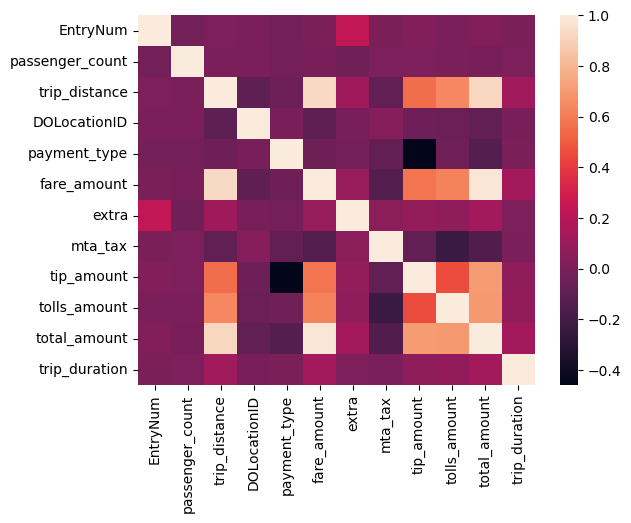

In [9]:
sns.heatmap(ddf.corr())

This heatmap is one that displays the correlation between different numerical features from our dataset. At any point on the heatmap, you are able to identify the correlation between two given variables. We see that the lighter shade indicates strong positive correlation while the darker color indicates strong negative correlation. Many of the different features that pertain to monetary value have correlation to one another because they will all play a part in producing the total_amount in the end. Otherwise, there are not significant correlations presented in the other features.

total cost:  12.07900382147874


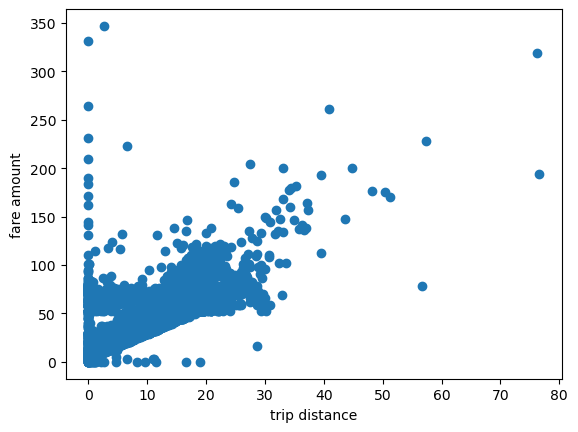

In [10]:
ddf=ddf.loc[ddf['trip_distance'] < 200]
ddf=ddf.loc[(ddf['total_amount'] < 2000) & (ddf['total_amount'] >= 0)]

x=ddf['trip_distance']
y=ddf['total_amount']

plt.scatter(x,y)
plt.xlabel("trip distance")
plt.ylabel("fare amount")
print("total cost: ", ddf["fare_amount"].mean())

This scatter plot shows the overall distribution of the different taxi trips when comparing fare amount to the trip's distance. The trend of the points seems to show a general trend with positive correlation. On the left-hand side we see several stray points climbing the side of the graph that serve to be outliers and we suspect these are outliers that came about as a result of human error due to the fact that these values are inputted by the taxi drivers and sometimes are not cleaned out. 

In [11]:
ddf = ddf.sort_values('PULocationID',ascending=True)
ddf

,EntryNum,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration,time_of_day
PULocationID,,,,,,,,,,,,,,,
1,8563897,2018-01-31 12:14:54,2018-01-31 12:15:03,5,0.00,1,2,100.0,0.0,0.5,0.00,0.0,100.80,0.150000,day
1,8510110,2018-01-31 09:23:15,2018-01-31 09:23:55,2,20.90,1,1,97.0,0.0,0.0,10.00,0.0,107.30,0.666667,day
1,8283937,2018-01-30 15:09:57,2018-01-30 15:10:22,2,0.00,1,1,90.8,0.0,0.0,2.00,0.0,93.10,0.416667,day
1,8329864,2018-01-30 17:17:23,2018-01-30 17:18:09,4,0.00,1,1,50.0,0.0,0.0,0.00,0.0,50.30,0.766667,day
3,8301498,2018-01-30 16:46:03,2018-01-30 17:01:49,2,4.58,213,2,16.5,1.0,0.5,0.00,0.0,18.30,15.766667,day
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265,8739103,2018-01-31 22:11:51,2018-01-31 22:11:56,2,0.00,265,2,57.0,0.0,0.0,0.00,0.0,57.30,0.083333,night
265,8375430,2018-01-30 20:27:22,2018-01-30 20:28:44,2,0.80,265,2,0.0,0.0,0.0,0.00,0.0,0.30,1.366667,night
265,8375429,2018-01-30 20:24:03,2018-01-30 20:24:43,2,0.80,265,2,0.0,0.0,0.0,0.00,0.0,0.30,0.666667,night


[Text(0.5, 0, 'time_of_day'), Text(0, 0.5, 'Number of Trips')]

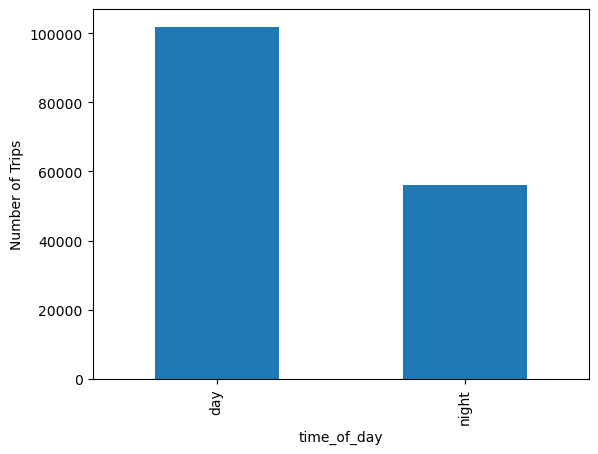

In [33]:
ddf['time_of_day'].value_counts().plot(kind='bar').set(xlabel='time_of_day', ylabel="Number of Trips")

The bar graph shows the number of trips that occurred in the day time and night time. In one day, we are able to see that there are more trips that occur during 6 AM to 6 PM. In the day time there are 410,286 trips, and in the night time there are 207,382 trips. The daytime occurrences are approximately 1.98 times more than night <br>
The fact that there are more daytime occurrences align with the idea that there is more traffic. People are going to work and tourists are traveling in the daytime. Most of the population is asleep at nighttime, so there are less trips occuring
this is for the bar graph.

Average trip cost during the day:    15.361111951084627 
Average trip cost during the night:  15.65592789651485


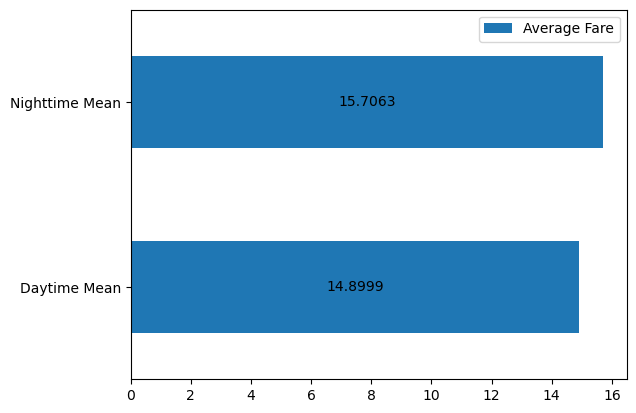

In [37]:
day = ddf[ddf['time_of_day'] == 'day']
daymean=day['total_amount'].mean()
night = ddf[ddf['time_of_day'] == 'night']
nightmean=night['total_amount'].mean()

print("Average trip cost during the day:   ", daymean, "\nAverage trip cost during the night: ",nightmean)




plotdata=pd.DataFrame({"Average Fare": [14.89986744596917,15.706328482029397]}, index=['Daytime Mean','Nighttime Mean'])
chart = plotdata.plot.barh()
for container in chart.containers:
    chart.bar_label(container, label_type='center')

This graph shows that the average fare for a nighttime trip is slightly higher than the average daytime trip. This can be attributed to the fact that the average trip that is taken at night has an average distance of 2.97, as opposed to the 2.41 of the daytime average. This increased distance means that the cost of the trips will be higher, something that is reflected in the graph

The average daytime duration in minutes:    17.526828462124932 
The average nighttime duration in minutes:  14.449301564140383 

average trip distance during the day:  2.550933858252257 
average trip distance during the night:  2.9868870224389252 



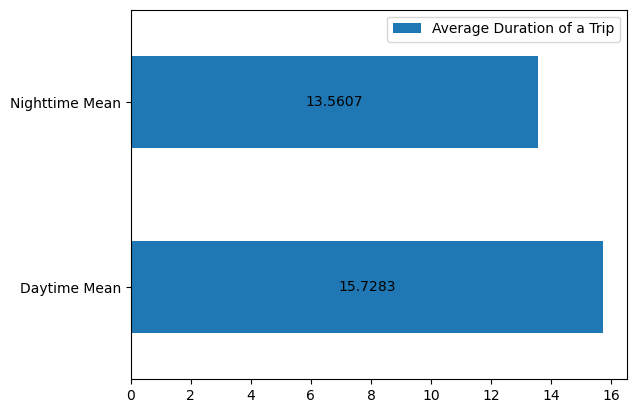

In [38]:
daytime=day['trip_duration'].mean()
nighttime=night['trip_duration'].mean()
print("The average daytime duration in minutes:   ",daytime,"\nThe average nighttime duration in minutes: ",nighttime,"\n")


daytrip=day['trip_distance'].mean()
nighttrip=night['trip_distance'].mean()
print("average trip distance during the day: ", daytrip ,"\naverage trip distance during the night: ", nighttrip,"\n")


duration=pd.DataFrame({"Average Duration of a Trip": [15.72831614995523,13.560657763285137]}, index=['Daytime Mean','Nighttime Mean'])
chart = duration.plot.barh()
for container in chart.containers:
    chart.bar_label(container, label_type='center')

When looking at this graph, there is a slight, but noticeable difference in the time that is spent during a trip. Previous analysis notes that the average distance of the ride is actually shorter during the day, but the graph shows that it actually takes longer for the average trip to complete during the day. This can be attributed to heavier traffic, which is most prevalent during the day. This means that despite the distance of the trip being shorter on average than at night, it actually takes longer to get to the destination.

# KNN Classification

We will utilize KNN (K-Nearest Neighbor) Classification in order to seek out a model that will utilize the various different features to predict whether a given trip record was during the day or at night. The KNN score that is produced will have a maximum value of 1.0 which would indicate that it very closely follows the trend of data and has high accuracy. 

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

In [14]:
TOD = ddf['time_of_day'].value_counts()
print(TOD)

day      101857
night     56197
Name: time_of_day, dtype: int64


As we can tell here, there is a fairly even split between the number of trips that were during the day (6AM to 6PM) and during the night (Before 6AM and after 6PM). 

In [15]:
ddf.head()

,EntryNum,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,total_amount,trip_duration,time_of_day
PULocationID,,,,,,,,,,,,,,,
1,8563897,2018-01-31 12:14:54,2018-01-31 12:15:03,5,0.00,1,2,100.0,0.0,0.5,0.0,0.0,100.8,0.150000,day
1,8510110,2018-01-31 09:23:15,2018-01-31 09:23:55,2,20.90,1,1,97.0,0.0,0.0,10.0,0.0,107.3,0.666667,day
1,8283937,2018-01-30 15:09:57,2018-01-30 15:10:22,2,0.00,1,1,90.8,0.0,0.0,2.0,0.0,93.1,0.416667,day
1,8329864,2018-01-30 17:17:23,2018-01-30 17:18:09,4,0.00,1,1,50.0,0.0,0.0,0.0,0.0,50.3,0.766667,day
3,8301498,2018-01-30 16:46:03,2018-01-30 17:01:49,2,4.58,213,2,16.5,1.0,0.5,0.0,0.0,18.3,15.766667,day


In [16]:
features = ddf[['passenger_count', 'trip_distance', 'total_amount', 'trip_duration']]
target = ddf['time_of_day']
X = features
y = target

In [17]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

knn = KNeighborsClassifier(n_neighbors=750)
knn.fit(X_train, y_train)
predict_knn = knn.predict(X_test)
expect_knn = y_test

print(classification_report(expect_knn, predict_knn, target_names=["Day", "Night"]))

              precision    recall  f1-score   support

         Day       0.74      0.85      0.79     30502
       Night       0.63      0.47      0.54     16915

    accuracy                           0.71     47417
   macro avg       0.69      0.66      0.66     47417
weighted avg       0.70      0.71      0.70     47417



In [18]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=750)

In [19]:
knn.score(X_test, y_test)

0.7124027247611616

The analysis above uses k = 750 (which is approximately the square root of 600,000). Our KNN score comes out to be approximately 0.71. From above, we see in the classification report that we are not necessarily hitting the max value of 1.0 so we will try adjusting our value for k in order to raise those numbers

In [20]:
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

knn = KNeighborsClassifier(n_neighbors=22)
knn.fit(X_train, y_train)
predict_knn = knn.predict(X_test)
expect_knn = y_test

print(classification_report(expect_knn, predict_knn, target_names=["Day", "Night"]))

              precision    recall  f1-score   support

         Day       0.78      0.83      0.80     30502
       Night       0.65      0.57      0.61     16915

    accuracy                           0.74     47417
   macro avg       0.72      0.70      0.71     47417
weighted avg       0.73      0.74      0.74     47417



In [21]:
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=22)

In [22]:
knn.score(X_test, y_test)

0.7398401417213236

After running numerous tests, we have found that when k=22 we have the highest KNN score being produced at 0.74. Although it is not a significant jump, it is still of greater value than our initial attempt. Our recall, f1-score, and accuracy in the classification report have also slightly improved. All in all, this is the best KNN Classifier value we got from the model, and it is ~74%. After creating the training and testing set, (which was portioned of into 30% and 70%), we ran the model and received insight on our data from the classification report. The precision, recall, and f1-score for Day were 0.78, 0.83, and 0.80 respectively. The precision, recall, and f1-score for Night were 0.65, 0.57, and 0.61 respectively. These numbers are not particularly impressive but are still carry some statistical significance. 

In [23]:
from sklearn.metrics import confusion_matrix

y_pred = knn.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

Text(58.222222222222214, 0.5, 'Truth')

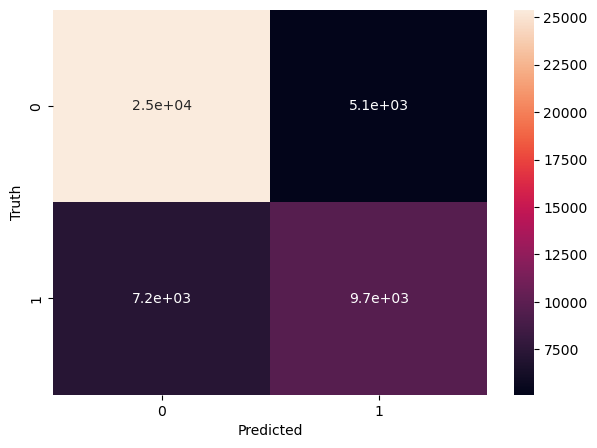

In [24]:
plt.figure(figsize=(7,5))
sns.heatmap(cm, annot=True)
plt.xlabel('Predicted')
plt.ylabel('Truth')

This heatmap displays how accurate our predictions were using this model. The top left and bottom right squares indicate the correct predictions while the top right and bottom left squares indicate when we were incorrect. The value 1 indicates day and 0 indicates night. We see hear that our prediction for day is much more accurate just like it showed on our classification report. Our predictions for night were not as accurate. 

# Decision Tree Classification

In [25]:
from sklearn.tree import DecisionTreeClassifier 
features = ddf[['passenger_count', 'trip_distance', 'total_amount', 'trip_duration']]
target = ddf['time_of_day']
X = features
y = target
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.3, random_state=0)

In [26]:
from sklearn import tree

clf = tree.DecisionTreeClassifier(max_depth = 2, criterion = "entropy")
clf = clf.fit(X_train, y_train)

y_pred = clf.predict(X_test)

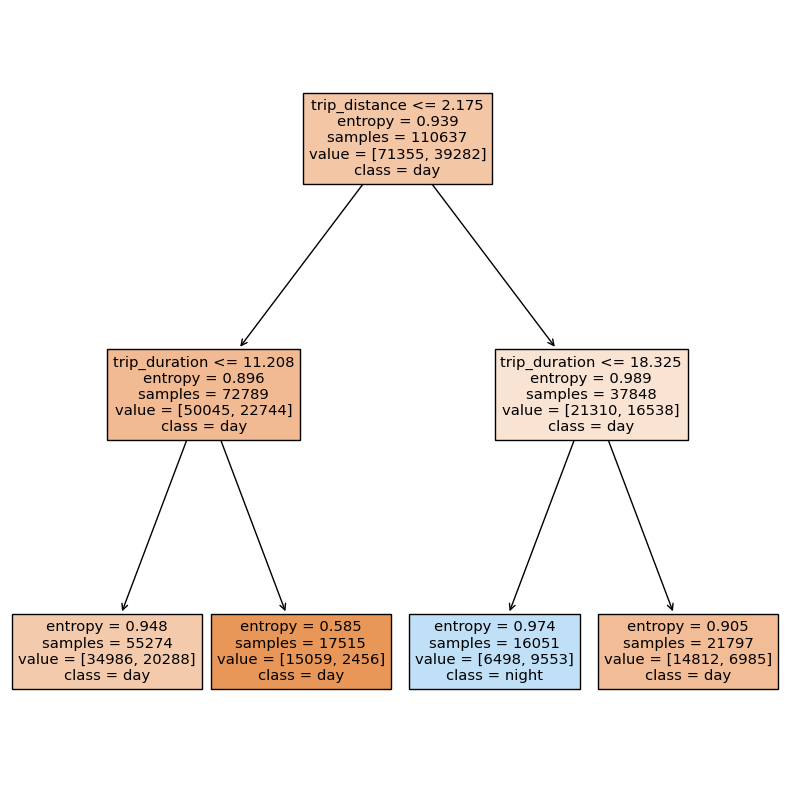

In [27]:
feature_names = ['passenger_count', 'trip_distance', 'total_amount', 'trip_duration']
class_names = ['day', 'night']

fig = plt.figure(figsize=(10,10))
plot = tree.plot_tree(clf, 
                      feature_names=feature_names, 
                      class_names=class_names, 
                      filled=True)

In [28]:
accuracy_score(y_test, y_pred)

0.6679671847649578

We see with this Decision Tree Classifier that the accuracy does not prove to be higher than that of the value we found from the KNN Classification. Our accuracy here is around ~67% which is still slightly lower than the KNN value of ~74%. In order to read this tree, we see at the top of the block is the feature trip_distance. Depending on whether it is less than or equal to the given value in the box, it will go down to the left child if it is true, or to the right if it is false. The entropy is an indication of the purity of each node and any sub-split. Value gives us the distribution of how many entries took place in the day and how many were at night. 

# Conclusion / Results
In the end, from the data we collected, cleaned, and performed EDA on, there are many points of analysis that we can draw from. Although the accuracy of our KNN Classification and Decision Tree Classification were not significantly strong (74% and 67% respectively), there was a lot that we were able to learn from the process of calculating these measures. Had we obtained a greater variety of features for this dataset, we would potentially see an improvement in the calculations we made. The original dataset had over 8 million trip records so being able to utilize more of that data may have been able to help. Unfortunately, it was too much for our poor laptops to handle when trying to compute all that data. 

### Contributions
Jonathan: Calculated the KNN Classification Model and Decision Tree Classification Model, Data Cleaning, Report <br>
Sathya Rajesh: converted the parquet to a csv, removed extreme outliers from the data, made some of the visualizations, report <br>
Samuel Ha: Data cleaning, visualization, EDA, assisted in KNN k-value determination, report <br>
Ian Oh: Data cleaning, visualization, slide presentation, report
